In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
class DatasetProcessor:
    def __init__(self, name):
        self.df = pd.read_csv(name).fillna(0)

    def calculate_innings_stats(self):
        self.df["innings_total"] = self.df.groupby(["match_id", "innings"])["runs_off_bat"].transform(lambda x : x.shift().fillna(0).cumsum()) + self.df.groupby(["match_id", "innings"])["extras"].transform(lambda x : x.shift().fillna(0).cumsum())
        self.df["wicket"] = (self.df["wicket_type"] != 0).astype(int)
        self.df["innings_wickets"] = self.df.groupby(["match_id", "innings"])["wicket"].transform(lambda x : x.shift().fillna(0).cumsum())
        self.df["chasing"] = (self.df.groupby(["match_id"], as_index=False)["innings_total"].transform("max") + 1) * (self.df.innings == 2).astype(int)
        
        self.df["ball"] = self.df["ball"].astype(int) * 6 + (self.df["ball"] - self.df["ball"].astype(int)) * 10
        self.df["over"] = self.df["ball"] // 6
        self.df["outcome"] = self.df.apply(lambda ball : 7 if ball["wicket"] == 1 else ball["runs_off_bat"], axis=1)

    def calculate_striker_stats(self):
        self.df["striker_runs"] = self.df.groupby(["match_id", "striker"])["runs_off_bat"].transform(lambda x : x.shift().fillna(0).cumsum())
        self.df["striker_balls"] = self.df.groupby(["match_id", "striker"])["runs_off_bat"].transform("cumcount")

    def calculate_bowler_stats(self):
        self.df["bowler_runs"] = self.df.groupby(["match_id", "bowler"])["runs_off_bat"].transform(lambda x : x.shift().fillna(0).cumsum())
        self.df["bowler_balls"] = self.df.groupby(["match_id", "bowler"])["runs_off_bat"].transform("cumcount")
        self.df["bowler_wickets"] = self.df.groupby(["match_id", "bowler"])["wicket"].transform(lambda x : x.shift().fillna(0).cumsum())

    def select_season(self, season):
        self.df = self.df[self.df.season == season]

    def process(self):
        self.select_season(2023)
        self.calculate_innings_stats()
        self.calculate_striker_stats()
        self.calculate_bowler_stats()
        self.df = self.df[self.df.outcome != 5]

        return self.df[["match_id",
                        "season", 
                        "venue", 
                        "innings", 
                        "innings_total",
                        "innings_wickets",
                        "chasing",
                        "ball", 
                        "over",
                        "striker",
                        "striker_runs", 
                        "striker_balls",
                        "bowler",
                        "bowler_runs",
                        "bowler_balls",
                        "bowler_wickets", 
                        "runs_off_bat",
                        "outcome"]]

In [57]:
class PlayerStatsProcessor:
    def __init__(self, df):
        self.df = df

    def batsmen_stats(self):
        dummies = pd.get_dummies(self.df.outcome).astype(int)
        striker_features = [
            "striker_0",
            "striker_1",
            "striker_2",
            "striker_3",
            "striker_4",
            "striker_6",
            "striker_wicket"
        ]

        self.df[striker_features] = dummies
        batsmen_stats = self.df.groupby("striker", as_index=False).agg({ f : "mean" for f in striker_features })
        balls_faced = self.df.groupby("striker", as_index=False).agg({ "striker_balls": "count" })
        average_stats = np.repeat(np.expand_dims(dummies.mean().values, axis=0), len(batsmen_stats), axis=0)
        W = (balls_faced["striker_balls"] / 100).map(lambda x : min(1, x))
        
        batsmen_stats[striker_features] = batsmen_stats[striker_features].mul(W, axis=0) + np.multiply(average_stats, 1 - W.to_numpy()[:, None])
        self.df[striker_features] = batsmen_stats[striker_features]
        return batsmen_stats
    
    def bowler_stats(self):
        dummies = pd.get_dummies(self.df.outcome).astype(int)
        bowler_features = [
            "bowler_0",
            "bowler_1",
            "bowler_2",
            "bowler_3",
            "bowler_4",
            "bowler_6",
            "bowler_wicket"
        ]

        self.df[bowler_features] = dummies
        bowler_stats = self.df.groupby("bowler", as_index=False).agg({ f : "mean" for f in bowler_features })
        balls_faced = self.df.groupby("bowler", as_index=False).agg({ "striker_balls": "count" })
        average_stats = np.repeat(np.expand_dims(dummies.mean().values, axis=0), len(bowler_stats), axis=0)
        W = (balls_faced["striker_balls"] / 100).map(lambda x : min(1, x))
        
        bowler_stats[bowler_features] = bowler_stats[bowler_features].mul(W, axis=0) + np.multiply(average_stats, 1 - W.to_numpy()[:, None])
        self.df[bowler_features] = bowler_stats[bowler_features]
        return bowler_stats

In [32]:
class ExpectedModel:
    def __init__(self, dataset):
        self.dataset = dataset

    def train(self):
        X = ["innings_total",
             "innings_wickets",
             "over", 
             "striker_runs", 
             "striker_balls",
             "bowler_runs",
             "bowler_balls",
             "bowler_wickets",
             "chasing"]
        
        Y = "outcome"

        pipeline = make_pipeline(StandardScaler(),
                                 MLPClassifier())
        
        dummies = self.dataset[Y]
        X_train, X_test, y_train, y_test = train_test_split(self.dataset[X], dummies, test_size=0.3)
        pipeline.fit(X_train, y_train)

        return pipeline

In [33]:
p = DatasetProcessor("IPL_ball_by_ball_updated.csv")
df = p.process()
trainer = ExpectedModel(df)

In [34]:
model = trainer.train()

C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [35]:
X = ["innings_total",
             "innings_wickets",
             "over", 
             "striker_runs", 
             "striker_balls",
             "bowler_runs",
             "bowler_balls",
             "bowler_wickets",
             "chasing"]

xR = (model.predict_proba(df[X]) * np.array([[0, 1, 2, 3, 4, 6, 0]])).sum(axis=1)
df["preds"] = xR

C:\Users\Ashwin\AppData\Local\Temp\ipykernel_21568\1145372410.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["preds"] = xR


C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

<Axes: xlabel='ball', ylabel='runs_off_bat'>

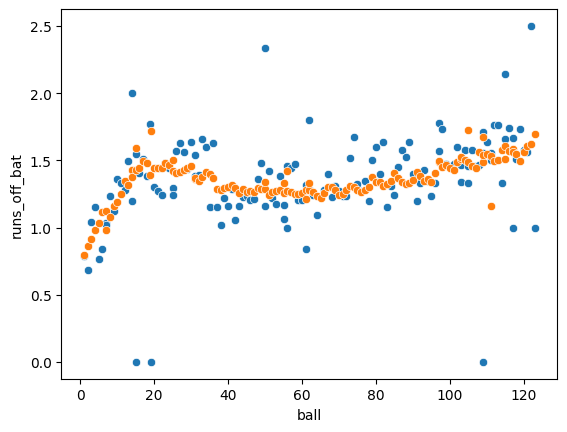

In [36]:
ball_group = df.groupby("ball", as_index=False).agg({ "runs_off_bat": "mean", "preds": "mean" })
sns.scatterplot(data=ball_group, x="ball", y="runs_off_bat")
sns.scatterplot(data=ball_group, x="ball", y="preds")

C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

<Axes: xlabel='striker_runs', ylabel='runs_off_bat'>

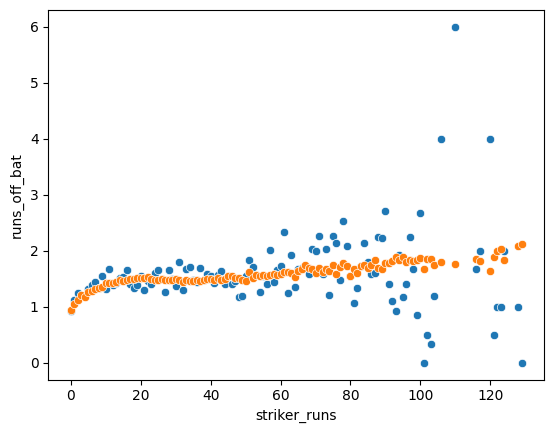

In [37]:
runs_group = df.groupby("striker_runs", as_index=False).agg({ "runs_off_bat": "mean", "preds": "mean" })
sns.scatterplot(data=runs_group, x="striker_runs", y="runs_off_bat")
sns.scatterplot(data=runs_group, x="striker_runs", y="preds")

C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

<Axes: xlabel='innings_total', ylabel='runs_off_bat'>

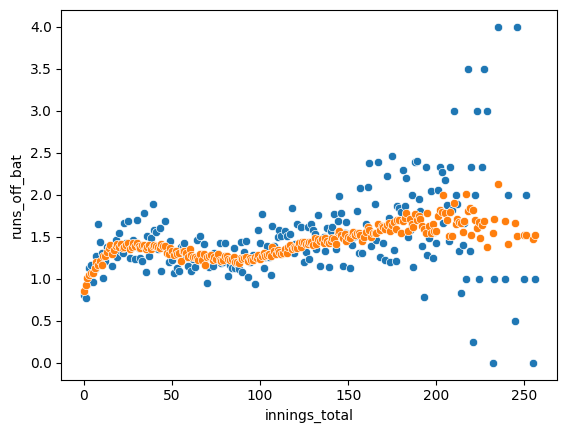

In [38]:
total_group = df.groupby("innings_total", as_index=False).agg({ "runs_off_bat": "mean", "preds": "mean" })
sns.scatterplot(data=total_group, x="innings_total", y="runs_off_bat")
sns.scatterplot(data=total_group, x="innings_total", y="preds")

In [39]:
import pickle
file = open("model.pkl", "wb")
pickle.dump(model, file)

In [59]:
p = PlayerStatsProcessor(df)
d = p.bowler_stats()

In [69]:
d
dict(zip(d.bowler, d.set_index("bowler").values))

{'bowler_0': array([0.33552881, 0.36776496, 0.06058283, 0.00249426, 0.12055596,
        0.0623011 , 0.05077207]),
 'bowler_1': array([0.22608696, 0.52173913, 0.05217391, 0.        , 0.08695652,
        0.05217391, 0.06086957]),
 'bowler_2': array([0.37051793, 0.29880478, 0.0876494 , 0.        , 0.1314741 ,
        0.06772908, 0.0438247 ]),
 'bowler_3': array([0.2406015 , 0.45112782, 0.06766917, 0.        , 0.11278195,
        0.06015038, 0.06766917]),
 'bowler_4': array([3.03288170e-01, 2.83714798e-01, 8.06119478e-02, 2.51945580e-05,
        1.81217737e-01, 8.06293041e-02, 7.05128492e-02]),
 'bowler_6': array([0.2999009 , 0.40232462, 0.04650803, 0.00191479, 0.13254801,
        0.06782711, 0.04897654]),
 'bowler_wicket': array([0.27769666, 0.42945468, 0.07120934, 0.00128492, 0.14210459,
        0.04209451, 0.03615531])}

In [67]:
d

,bowler,bowler_0,bowler_1,bowler_2,bowler_3,bowler_4,bowler_6,bowler_wicket
0,A Badoni,0.335529,0.367765,0.060583,0.002494,0.120556,0.062301,0.050772
1,A Mishra,0.226087,0.521739,0.052174,0.000000,0.086957,0.052174,0.060870
2,A Nortje,0.370518,0.298805,0.087649,0.000000,0.131474,0.067729,0.043825
3,A Zampa,0.240602,0.451128,0.067669,0.000000,0.112782,0.060150,0.067669
4,AD Russell,0.303288,0.283715,0.080612,0.000025,0.181218,0.080629,0.070513
...,...,...,...,...,...,...,...,...
131,Washington Sundar,0.301887,0.415094,0.084906,0.000000,0.113208,0.056604,0.028302
132,YS Chahal,0.257669,0.432515,0.095092,0.006135,0.095092,0.046012,0.067485
133,Yash Dayal,0.299458,0.354578,0.057343,0.000302,0.134613,0.127552,0.026154
134,Yash Thakur,0.338164,0.357488,0.062802,0.000000,0.091787,0.077295,0.072464
